<a href="https://colab.research.google.com/github/andreibuiciuc/MNIST-Classifier/blob/main/mnist_classifier_tf_noCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MNIST Classifier with Tensorflow**

In this notebook, one builts a MNIST classifier (without CNN) as a Tensorflow program. The implementation is OOP oriented and is based on tensorflow's features.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

%matplotlib inline

print("Setup done.")

Setup done.


Load the MNIST dataset - the keras API offers a quick way to fetch and split the dataset into training and testing sets.

In [2]:
(x_train_np, y_train_np), (x_test_np, y_test_np) = tf.keras.datasets.mnist.load_data()

print("Number of training examples: ", x_train_np.shape[0])
print("Number of testing examples: ", x_test_np.shape[0])

Number of training examples:  60000
Number of testing examples:  10000


The method above returns numpy arrays. Convert them into Tensorflow datasets.

In [3]:
# Create tf train datasets from numpy arrays
x_train = tf.data.Dataset.from_tensor_slices(x_train_np)
y_train = tf.data.Dataset.from_tensor_slices(y_train_np)

# Create tf test datasets from numpy arrays
x_test = tf.data.Dataset.from_tensor_slices(x_test_np)
y_test = tf.data.Dataset.from_tensor_slices(y_test_np)


Check the type and dimensions for the previously created datasets.

In [4]:
print("Check for training set: ")
print("x_train type: ", type(x_train))
print("x_train spec: ", x_train.element_spec)
print("y_train type: ", type(y_train))
print("y_train spec: ", y_train.element_spec)

print("\nCheck for testing set: ")
print("x_test type: ", type(x_test))
print("x_test spec: ", x_test.element_spec)
print("y_test type: ", type(y_test))
print("y_test spec: ", y_test.element_spec)

Check for training set: 
x_train type:  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
x_train spec:  TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None)
y_train type:  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
y_train spec:  TensorSpec(shape=(), dtype=tf.uint8, name=None)

Check for testing set: 
x_test type:  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
x_test spec:  TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None)
y_test type:  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
y_test spec:  TensorSpec(shape=(), dtype=tf.uint8, name=None)


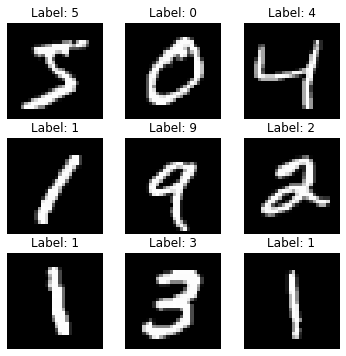

In [5]:
# Explore the MNIST dataset

fig = plt.figure(figsize=(6,6))
axes = []
index = 0
rows = 3
columns = 3

for i in range(rows * columns):
  axes.append(fig.add_subplot(rows, columns, i+1))
  axes[index].set_title("Label: " + str(np.squeeze(y_train_np[index])))
  axes[index].axis('off')
  plt.imshow(x_train_np[index], cmap='gray')
  index += 1

plt.show() 

### **Model Implementation**

For this problem, one builds a deep neural network model with an OOP approach. 
The implementation is straightforward and consists of a model class having features helpful for the forward propagation part. Because using tensorflow, computations are recorded in a graph with Gradient Tape and then, by moving backwards, gradients are automatically calculated without the programmer's intervention.

This model uses **Adam** as optimazation (which can be seen as a combination of gradient descent with momentum and RMSprop) and it has a custom training loop for training in minibatches. **ReLU** is used as activation function in the hidden layers and **Softmax** for the output layer.

In [6]:
class Model:
  def __init__(self, x_train, y_train, x_test, y_test, hidden_dimensions,
               learning_rate=0.001, epochs=100, minibatch_size=32, print_cost=True):
    self.__x_train = x_train
    self.__y_train = y_train
    self.__x_test = x_test
    self.__y_test = y_test
    self.__dimensions = self.__set_dimensions(hidden_dimensions)
    self.__learning_rate = learning_rate
    self.__epochs = epochs
    self.__minibatch_size = minibatch_size
    self.__print_cost = print_cost
    self.__parameters = {}
  
  @staticmethod
  def __set_dimensions(hidden_dimensions):
    """
    Sets the model's dimensions.
    """
    # The input has 784 units
    dimensions = [784]
    
    for dim in hidden_dimensions:
      dimensions.append(dim)
    
    # The output has 10 units
    dimensions.append(10)

    return dimensions

  def get_info(self):
    """
    Provides the used metrics.
    """
    d = {"parameters": self.__parameters, 
         "learning_rate": self.__learning_rate,
         "epochs": self.__epochs,
         "minibatch_size": self.__minibatch_size,
         "dimensions": self.__dimensions}
    
    return d

  def __init_parameters(self):
    """
    Initializes parameters using Glorot (Xavier) initialization method. 
    """
    initializer = tf.keras.initializers.GlorotNormal()
    
    for l in range(1, len(self.__dimensions)):
      self.__parameters["W"+str(l)] = tf.Variable(initializer(shape=(self.__dimensions[l], self.__dimensions[l-1])))
      self.__parameters["b"+str(l)] = tf.Variable(initializer(shape=(self.__dimensions[l], 1)))    
    
  def __standardize(self, input):
    """
    Standardizes and reshapes an image input from the dataset.
    """
    # Reshape
    input = tf.reshape(input, [-1,])
    # Standardize
    input = tf.cast(input, tf.float32) / 255.
    return input
  
  def __one_hot(self, label, classes=10):
    """
    Creates an one-hot single column matrix for a given label.
    """
    one_hot = tf.one_hot(label, classes)
    one_hot = tf.reshape(one_hot, (classes,))
    return one_hot

  def __linear_forward(self, X):
    """
    Computes the linear part of forward propagation.
    """
    A = X
    for l in range(1, (len(self.__parameters) // 2)):
      Z = tf.add(tf.matmul(self.__parameters["W"+str(l)], A), self.__parameters["b"+str(l)])
      A = tf.keras.activations.relu(Z)
    
    L = len(self.__parameters) // 2
    Z = tf.add(tf.matmul(self.__parameters["W"+str(L)], A), self.__parameters["b"+str(L)])
    # Do not apply Softmax, the cost function will automatically do so.
    return Z
  
  def __compute_cost(self, logits, labels):
    """
    Computes the categorical cross-entropy cost.
    """
    cost = tf.keras.losses.categorical_crossentropy(tf.transpose(labels), tf.transpose(logits), from_logits=True)
    cost = tf.reduce_mean(cost)
    return cost
  
  def predict(self, x):
    """
    Predicts the label of an image.
    """
    z = self.__linear_forward(x)
    a = tf.divide(tf.exp(z), tf.reduce_sum(tf.exp(z)))
    y_hat = tf.math.argmax(a)
    return y_hat

  def fit(self):
    """
    Builds the model.
    """
    # Initialize the parameters
    self.__init_parameters()

    # Standardize the data
    self.__x_train = self.__x_train.map(self.__standardize)
    self.__x_test = self.__x_test.map(self.__standardize)

    # Convert labels as one hot matrices
    self.__y_train = self.__y_train.map(self.__one_hot)
    self.__y_test = self.__y_test.map(self.__one_hot)

    # Keep track of costs and accuracies
    costs = []
    train_accuracies = []
    test_accuracies = []

    #Initialize the train and test accuracy
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Set the optimizer
    optimizer = tf.keras.optimizers.Adam(self.__learning_rate)

    # Create train and test datasets containing both features and labels
    train_dataset = tf.data.Dataset.zip((self.__x_train, self.__y_train))
    test_dataset = tf.data.Dataset.zip((self.__x_test, self.__y_test))

    # Create mininatches
    train_minibatches = train_dataset.batch(self.__minibatch_size)
    test_minibatches = test_dataset.batch(self.__minibatch_size)

    # Start training
    for epoch in range(self.__epochs):
      # Initialize the cost of the current epoch.
      cost = .0

      # Reset train and test accuracies before computing them.
      train_accuracy.reset_states()
      test_accuracy.reset_states()

      # Forward propagation
      for (mini_x, mini_y) in train_minibatches:
        with tf.GradientTape() as tape:
          Z = self.__linear_forward(tf.transpose(mini_x))
          mini_cost = self.__compute_cost(Z, tf.transpose(mini_y))

        # Provide only the logits since argmax of logits and probabilities
        # are the same
        train_accuracy.update_state(tf.transpose(Z), mini_y)

        # Convert the dictionary containing parameters into a list of
        # trainable variables needed for both computing the gradients and
        # performing the Adam optimization
        trainable = list(self.__parameters.values())
        grads = tape.gradient(mini_cost, trainable)
        optimizer.apply_gradients(zip(grads, trainable))

        cost = cost + mini_cost

      # Compute the cost of the current epoch
      cost = cost / train_dataset.cardinality().numpy()

      if epoch % 10 == 0 and self.__print_cost is True:
        print("Cost after epoch: ", epoch, ": ", cost)
        print("Train accuracy: ", train_accuracy.result())

        # Evaluate also the testing set.
        for (mini_x, mini_y) in test_minibatches:
          Z = self.__linear_forward(tf.transpose(mini_x))
          test_accuracy.update_state(tf.transpose(Z), mini_y)
        
        print("Test accuracy: ", test_accuracy.result())
        print("\n")

      if epoch % 10 == 0:
        costs.append(cost)
        train_accuracies.append(train_accuracy.result())
        test_accuracies.append(test_accuracy.result())
    
    return costs, train_accuracies, test_accuracies

Set the dimensions (hidden layers only, no input or output) and then initialize a model.

In [7]:
hidden_dimensions = [32, 16]
model = Model(x_train, y_train, x_test, y_test, hidden_dimensions, 
              learning_rate=0.0003, 
              epochs=50, 
              minibatch_size=32, 
              print_cost=True)

In [8]:
costs, train_acc, test_acc = model.fit()

Cost after epoch:  0 :  tf.Tensor(0.020634495, shape=(), dtype=float32)
Train accuracy:  tf.Tensor(0.80973333, shape=(), dtype=float32)
Test accuracy:  tf.Tensor(0.9144, shape=(), dtype=float32)


Cost after epoch:  10 :  tf.Tensor(0.00357145, shape=(), dtype=float32)
Train accuracy:  tf.Tensor(0.96648335, shape=(), dtype=float32)
Test accuracy:  tf.Tensor(0.956, shape=(), dtype=float32)


Cost after epoch:  20 :  tf.Tensor(0.002329879, shape=(), dtype=float32)
Train accuracy:  tf.Tensor(0.9784, shape=(), dtype=float32)
Test accuracy:  tf.Tensor(0.9622, shape=(), dtype=float32)


Cost after epoch:  30 :  tf.Tensor(0.0016617246, shape=(), dtype=float32)
Train accuracy:  tf.Tensor(0.9848667, shape=(), dtype=float32)
Test accuracy:  tf.Tensor(0.9636, shape=(), dtype=float32)


Cost after epoch:  40 :  tf.Tensor(0.0012045094, shape=(), dtype=float32)
Train accuracy:  tf.Tensor(0.98985, shape=(), dtype=float32)
Test accuracy:  tf.Tensor(0.964, shape=(), dtype=float32)




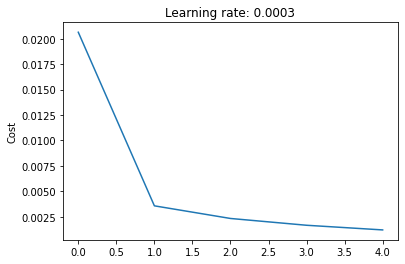

In [9]:
# Plot the cost

d = model.get_info()
plt.plot(np.squeeze(costs))
plt.title("Learning rate: " + str(d["learning_rate"]))
plt.ylabel("Cost")
plt.show()

Test the model on a random images outside the datasets. The loaded images are converted to grayscale and then inverted to match the MNIST convention.

In [10]:
def convert_image_to_tensor(path):
  digit_image = Image.open(path).convert('L')
  digit_image = digit_image.resize((28, 28))
  digit_image_rev = ImageOps.invert(digit_image)

  digit_np = np.array(digit_image_rev)

  digit_tf = tf.convert_to_tensor(digit_np)
  digit_tf = tf.reshape(digit_tf, (784, 1))
  digit_tf = tf.cast(digit_tf, tf.float32) / 255.

  return digit_np, digit_tf

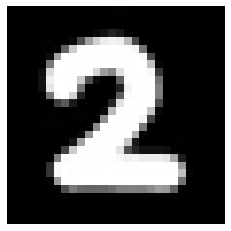

In [12]:
digit_2_path = r'/content/Drawing2.jpeg'
digit_2_np, digit_2_tf = convert_image_to_tensor(digit_2_path)
plt.imshow(digit_2_np, cmap='gray')
plt.axis('off')
plt.show()

Predict the label by calling the prediction method on the tensor representing the image.

In [13]:
y = model.predict(digit_2_tf)
print("Label predicted: ", np.squeeze(y.numpy()))

Label predicted:  2


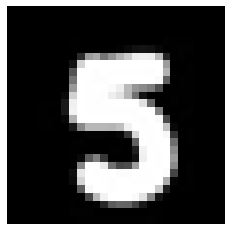

In [14]:
digit_5_path = r'/content/Drawing5.jpeg'
digit_5_np, digit_5_tf = convert_image_to_tensor(digit_5_path)
plt.imshow(digit_5_np, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
y = model.predict(digit_5_tf)
print("Label predicted: ", np.squeeze(y.numpy()))

Label predicted:  5


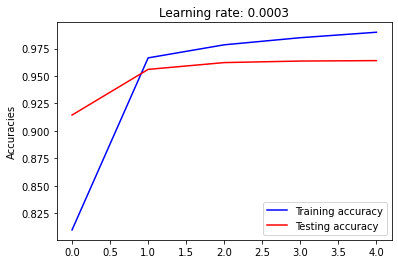

In [16]:
# Plot the training and testing accuracies

plt.plot(np.squeeze(train_acc), 'b', label='Training accuracy')
plt.plot(np.squeeze(test_acc), 'r', label='Testing accuracy')
plt.ylabel("Accuracies")
plt.title("Learning rate: " + str(d["learning_rate"]))
plt.legend(loc='lower right')
plt.show()